<a href="https://colab.research.google.com/github/pyagoubi/Credit-Default-Prediction/blob/main/Amex_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

#set WD
import os
os.chdir('/content/drive/MyDrive/Amex/parquet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <b> Description </b>
The objective of this competition is to predict the probability that a customer does not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

**`D_*`:** Delinquency variables  
**`S_*`:** Spend variables  
**`P_*`:** Payment variables  
**`B_*`:** Balance variables  
**`R_*`:** Risk variables  
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.

# <b> Import Libriaries and Read Data </b>

In [2]:
import pandas as pd
import numpy as np
import pickle, gc
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [3]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    df = pd.read_parquet(path, columns=usecols)
    df['customer_ID'] = df['customer_ID'].str[-16:].apply(int, base =16)
    df.S_2 = pd.to_datetime( df.S_2 )
    #print('shape of data:', df.shape)
    return df

In [4]:
train = read_file(path='train.parquet')
test = read_file(path='test.parquet')
target =pd.read_csv('train_labels.csv')

# <b> Overview </b>

In [5]:
print('The train dataset has {:,d} rows and the test dataset has {:,d} rows. There are {} columns.'.format(train.shape[0], test.shape[0], train.shape[1]))

The train dataset has 5,531,451 rows and the test dataset has 11,363,762 rows. There are 190 columns.


In [6]:
train.info(max_cols=300 ,show_counts = True )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  uint64        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float32       
 3    D_39         5531451 non-null  int16         
 4    B_1          5531451 non-null  float32       
 5    B_2          5529435 non-null  float32       
 6    R_1          5531451 non-null  float32       
 7    S_3          4510907 non-null  float32       
 8    D_41         5529435 non-null  float32       
 9    B_3          5529435 non-null  float32       
 10   D_42         791314 non-null   float32       
 11   D_43         3873055 non-null  float32       
 12   D_44         5531451 non-null  int8          
 13   B_4          5531451 non-null  int16         
 14   D_45         5529434 non-null  float32       
 1

# <b>Analysing Null values</b>

In [7]:
missing = pd.DataFrame(columns = ['% Missing values'],data = 100*round(train.isnull().sum().sort_values(ascending = False)/len(train),2))

In [8]:
pd.set_option("display.max_rows", 30)

In [9]:
display(missing)

,% Missing values
D_88,100.0
D_110,99.0
B_39,99.0
D_73,99.0
B_42,99.0
...,...
D_78,0.0
D_79,0.0
R_8,0.0
R_9,0.0


Insight: There are variables with a high number of missing values, these might have to be dropped.

In [10]:
missing[missing['% Missing values']>70].shape

(12, 1)

In [11]:
print('There are 12 variables with more than 70% missing values.')

There are 12 variables with more than 70% missing values.


# <b>Target variable</b>

In [22]:
tmp

,index,target
0,0,74.106639
1,1,25.893361


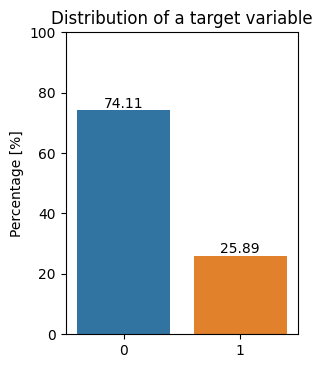

In [49]:
tmp = pd.DataFrame(data =target['target'].value_counts().div(len(target)).mul(100), columns = ['target']).reset_index()

fig = plt.figure(figsize=(3, 4), dpi=100)
ax = sns.barplot(x=tmp.index, y=tmp.target)
#ax.bar_label(ax.containers[0], fmt='%.f%%')
ax.set_ylim(0, 100)
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")

for index, row in tmp.iterrows():
    ax.text(row.name, row.target + 1, round(row.target, 2),
            color='black', ha='center')

plt.show()

The dataset is imbalanced

# <b>How many statements per customer</b>

In [50]:
target['customer_ID'] = target['customer_ID'].str[-16:].apply(int, base =16)
train = train.merge(target, on ='customer_ID')

In [52]:
presence

,customer_ID,target,presence
0,3249127622875,0,13
1,23402014749356,1,13
2,37423844044824,1,13
3,149683802139734,0,13
4,160820792638518,1,13
...,...,...,...
458908,18446623475205808948,1,13
458909,18446629179309953275,0,7
458910,18446635398005430687,0,13
458911,18446654790786387807,0,13


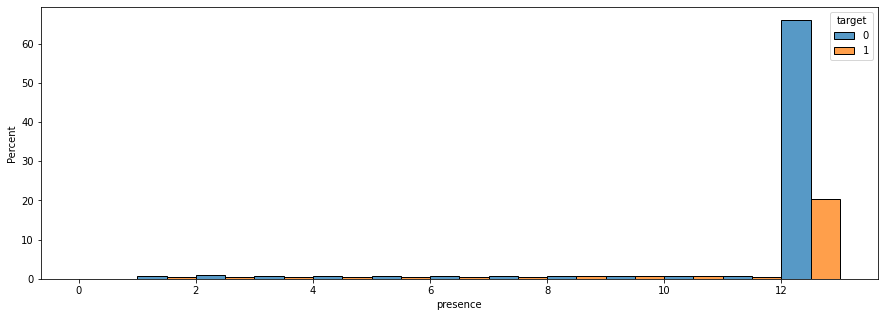

In [56]:
presence = train.groupby(['customer_ID','target']).size().reset_index().rename(columns={0:'presence'})

fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
plt.show()

Most customers have 13 statements.

# <b>Delinquency variables</b>

ValueError: ignored

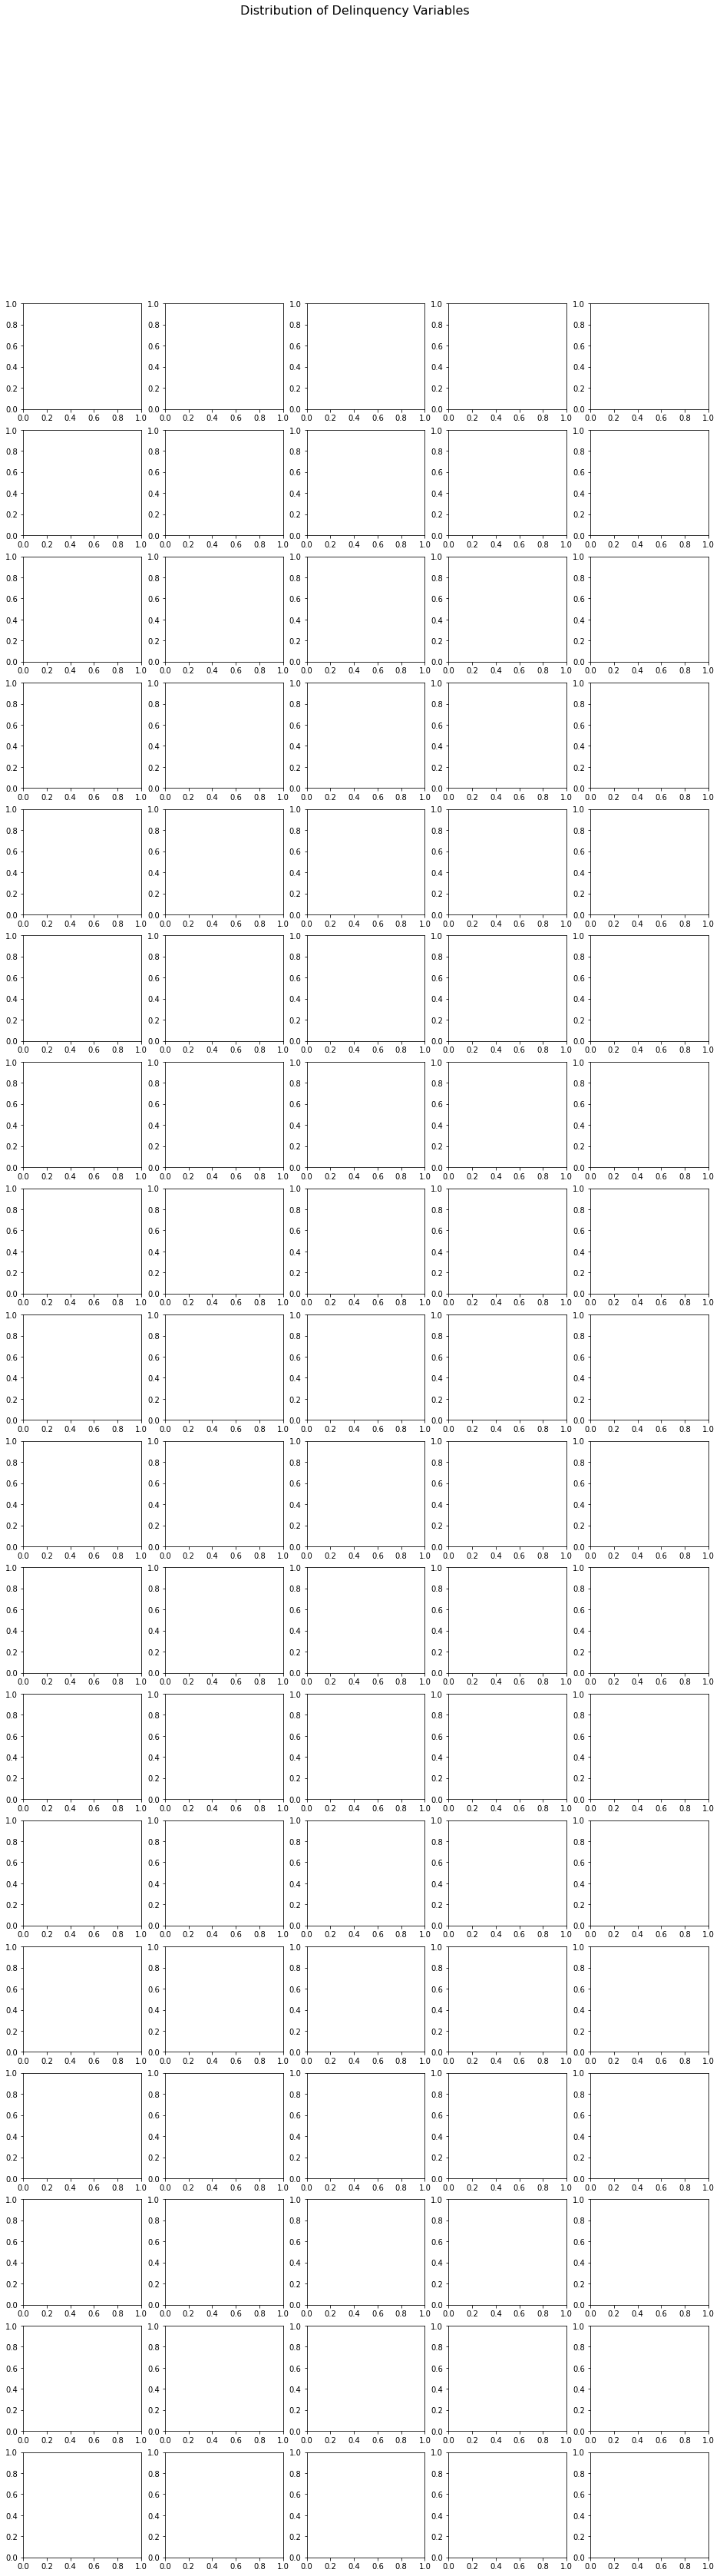

In [59]:
cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target']
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
cols=[col for col in train.columns if (col.startswith(('D','T'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='Target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])